In [1]:
import sys
from pathlib import Path

# Add the root project folder to the python path in order to use the packages
path_root = Path( '/project_ghent/HADSP/hadsp/')
sys.path.append(str(path_root))

In [2]:
import numpy as np
from scipy import sparse
from tqdm import tqdm
from importlib import reload

# SEED
SEED = 49387

from matplotlib import pyplot as plt
from seaborn import heatmap, color_palette

# Datasets loading

Lots of different on availabale : https://towardsdatascience.com/a-data-lakes-worth-of-audio-datasets-b45b88cd4ad

Classification: 
https://arxiv.org/abs/1803.07870

https://github.com/FilippoMB/Time-series-classification-and-clustering-with-Reservoir-Computing

Multivariate:
https://www.timeseriesclassification.com/dataset.php

## Torchaudio

https://pytorch.org/audio/stable/datasets.html


## Prediction ahead

Datasets available :

* MackeyGlass
* Lorenz

from datasets.load_datasets import load_dataset_prediction
is_instances_classification = False
dataset_name = "MackeyGlass"
step_ahead=5

is_multivariate, sampling_rate, X_train, X_test, Y_train, Y_test = load_dataset_prediction(dataset_name, step_ahead, visualize=True)


## Classification

Datasets available :

* FSDD
* HAART
* JapaneseVowels

In [3]:
from datasets.load_datasets import load_dataset_classification
is_instances_classification = True
dataset_name = "JapaneseVowels"

is_multivariate, sampling_rate, X_train, X_test, Y_train, Y_test, groups = load_dataset_classification(dataset_name)

## Formating

### Multivariate Naming

In [4]:
if is_multivariate:
    X_train_band, X_test_band = X_train, X_test
    del X_train, X_test

### Check data formating

In [5]:
if is_instances_classification:
    common_index = 1
else:
    common_index = 0

if is_multivariate and is_instances_classification:
    print("Common index for multivariate classification should be 1")
    print("\nCheck it ! \nFirst array ", X_train_band[0].shape, " and second array", X_train_band[2].shape)
    common_size = X_train_band[0].shape[common_index]
elif is_multivariate and not is_instances_classification:
    print("Common index for multivariate prediction should be 0")
    common_size = X_train_band.shape[common_index]


Common index for multivariate classification should be 1

Check it ! 
First array  (20, 12)  and second array (22, 12)


# Reservoir

## Activation function

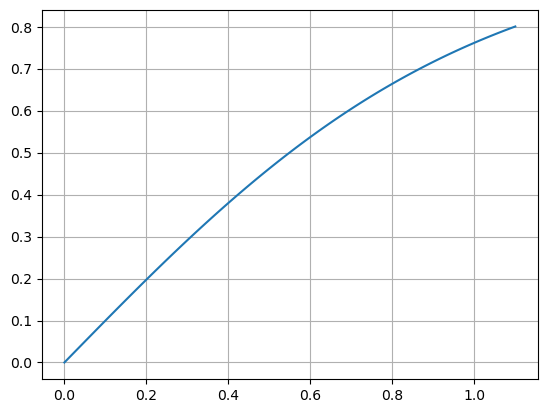

In [6]:
from reservoir.activation_functions import tanh, heaviside, sigmoid

# the activation function choosen for the rest of the experiment
# activation_function = lambda x : sigmoid(2*(x-0.5))tanh(x)
activation_function = lambda x : tanh(x)

plt.plot(np.linspace(0, 1.1, 100), activation_function(np.linspace(0, 1.1, 100)))
plt.grid()

## Set reservoir size

**common_size** : the number of different dimensions in the input data

**K** : the number of neurons that will receive a particular time serie as input 

In [7]:
RESERVOIR_SIZE = 500

# Preprocessing

Spectrograms_vs_Cochleagrams : https://www.researchgate.net/publication/340510607_Speech_recognition_using_very_deep_neural_networks_Spectrograms_vs_Cochleagrams

Attention ! For multivariate shape should be : (nb_of_timeseries, nb_of_timesteps)

## Multivariate generation (if not multivariate) and train_validation split

Frequency limit:  5000.0 (Shannon sampling theorem)


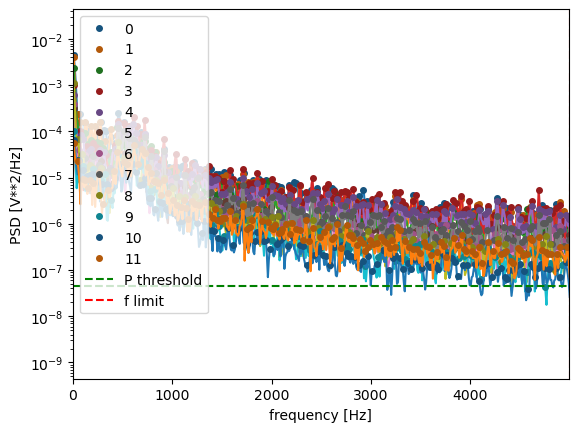

Number of frequencies selected : 12


/Users/tanguy/Code/Finebouche/hadsp/datasets/multivariate_generation.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(filtered_peak_freqs)


In [8]:
from datasets.multivariate_generation import generate_multivariate_dataset, extract_peak_frequencies
from sklearn.model_selection import train_test_split, GroupShuffleSplit

# Split
val_size=0.1
if is_multivariate:
    X_train_band, X_val_band, Y_train, Y_val = train_test_split(X_train_band, Y_train, test_size=val_size, shuffle=False, random_state=SEED)
    freq_train_data = X_train_band
else:
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=val_size, shuffle=False, random_state=SEED)
    freq_train_data = X_train

if is_instances_classification:
    flat_train_data = np.concatenate(freq_train_data, axis=0)
else:
    flat_train_data = freq_train_data
filtered_peak_freqs = extract_peak_frequencies(flat_train_data, sampling_rate, threshold=1e-5, nperseg=1024, visualize=True)

#print("Filtered peak frequencies: ", filtered_peak_freqs)
print("Number of frequencies selected :", len(filtered_peak_freqs))

if not is_multivariate:
    common_size = len(filtered_peak_freqs)
    X_train_band = generate_multivariate_dataset(
        filtered_peak_freqs, X_train, sampling_rate, is_instances_classification, nb_jobs=-1
    )
    X_val_band = generate_multivariate_dataset(
        filtered_peak_freqs, X_val, sampling_rate, is_instances_classification, nb_jobs=-1
    )
    X_test_band = generate_multivariate_dataset(
        filtered_peak_freqs, X_test, sampling_rate, is_instances_classification, nb_jobs=-1
    )


### set common size

**common_size** : the number of different dimensions in the input data

**K** : the number of neurons that will receive a particular time serie as input 

In [9]:
import math 

# We want the size of the reservoir to be at least 200
K = math.ceil(RESERVOIR_SIZE / common_size)
n = common_size * K
print("Dimension of our reservoir :", n)
print("Copy of each time serie :", K)

Dimension of our reservoir : 504
Copy of each time serie : 42


### Visualisation

In [10]:
if not is_instances_classification:
    # Concatenate train and test arrays for plotting
    combined_data = np.concatenate((X_train_band, X_val_band), axis=0)
    combined_Y =np.concatenate((Y_train, Y_val), axis=0)
    
    # Calculate the merge point index
    merge_point_index = X_train_band.shape[0]
    
    # Define the range around the merge point to plot
    start_index = merge_point_index - 1000
    end_index = merge_point_index + 1000
    steps = range(start_index, end_index)
    
    print(start_index, end_index)
    # Plot for a subset N features within a range arround transition from train to test
    plt.figure(figsize=(16, 5))
    for i in [0, 2, 10]: 
        plt.plot(steps, combined_data[steps, i], label=f'Feature {i}')
    #plt.plot(steps, combined_Y[steps], label="Prediction")
    plt.title('Feature Values Around Merge Point')
    plt.xlabel('Sample Index')
    plt.ylabel('Feature Value')
    plt.legend()
    plt.show()

## Standardizing the amplitudes

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler_x_uni = MinMaxScaler(feature_range=(0, 1))
scaler_x_multi = MinMaxScaler(feature_range=(0, 1))

if is_instances_classification:
    print("processing for Classification")
    # Transform the training, validation and test data using the same scaler
    scaler_x_multi.fit(np.concatenate(X_train_band, axis=0))

    X_train_band = np.array([scaler_x_multi.transform(time_series) for time_series in tqdm(X_train_band)])
    X_val_band = np.array([scaler_x_multi.transform(time_series) for time_series in tqdm(X_val_band)])
    X_test_band = np.array([scaler_x_multi.transform(time_series) for time_series in tqdm(X_test_band)])

    if not is_multivariate:
        # Transform the training, validation and test data using the same scaler
        X_train = np.array([scaler_x_uni.transform(x).flatten() for x in tqdm(X_train)])
        X_val = np.array([scaler_x_uni.transform(x).flatten() for x in tqdm(X_val)])
        X_test = np.array([scaler_x_uni.transform(x).flatten() for x in tqdm(X_test)])
else :
    print("processing for Prediction")
    # FOR MULTIVARIATE DATA
    X_train_band = scaler_x_multi.fit_transform(X_train_band)
    X_val_band = scaler_x_multi.transform(X_val_band)
    X_test_band = scaler_x_multi.transform(X_test_band)
    
    if not is_multivariate:
        X_train = scaler_x_uni.fit_transform(X_train)
        X_val = scaler_x_uni.transform(X_val)
        X_test = scaler_x_uni.transform(X_test)



processing for Classification


100%|████████████████████████████████████████████████| 243/243 [00:00<00:00, 38886.53it/s]
/var/folders/c9/p_q1xbbj7sv7nwvd_17c75lh0000gn/T/ipykernel_30132/440551317.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_band = np.array([scaler_x_multi.transform(time_series) for time_series in tqdm(X_train_band)])
100%|██████████████████████████████████████████████████| 27/27 [00:00<00:00, 36780.19it/s]
/var/folders/c9/p_q1xbbj7sv7nwvd_17c75lh0000gn/T/ipykernel_30132/440551317.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_val_band = np

## Timeseries duplications and noizing

In [12]:
# Define noise parameter
noise_std = 0.05


### Pretrain

In [13]:
# PRETRAIN NOISE
# MULTI
X_pretrain_band = X_train_band
X_pretrain_band_noisy = [instance + np.random.normal(0, noise_std, instance.shape) for instance in X_pretrain_band]

# UNI
if not is_multivariate:
    X_pretrain_uni = X_train.flatten()
    X_pretrain_uni_noisy = (X_train + np.random.normal(0, noise_std, X_train.shape)).flatten()
    
# PRETRAIN DUPLICATION
if is_instances_classification:
    X_pretrain_multi = []
    X_pretrain_multi_noisy = []
    for instance in X_pretrain_band:
        X_pretrain_multi.append(np.repeat(instance, K, axis=1).T)
    for instance in X_pretrain_band_noisy:
        X_pretrain_multi_noisy.append(np.repeat(instance, K, axis=1).T)
else:
    X_pretrain_multi = np.repeat(X_pretrain_band, K, axis=1)
    X_pretrain_multi_noisy = np.repeat(X_pretrain_band_noisy, K, axis=1)

### For classification

In [14]:
if is_instances_classification:
    # NOISE
    # UNI
    
    # MULTI
    X_train_band_noisy = [instance + np.random.normal(0, noise_std, instance.shape) for instance in tqdm(X_train_band, desc="TRAIN")]
    X_val_band_noisy = [instance + np.random.normal(0, noise_std, instance.shape) for instance in tqdm(X_val_band, desc="VAL")]
    X_test_band_noisy = [instance + np.random.normal(0, noise_std, instance.shape) for instance in tqdm(X_test_band, desc="TEST")]

    # DUPLICATION
    X_train_band_duplicated = []
    X_train_band_noisy_duplicated = []
    for i in tqdm(range(len(X_train_band))):
        X_train_band_duplicated.append(np.repeat(X_train_band[i], K, axis=1))
        X_train_band_noisy_duplicated.append(np.repeat(X_train_band_noisy[i], K, axis=1))

    X_val_band_duplicated = []
    X_val_band_noisy_duplicated = []
    for i in tqdm(range(len(X_val_band))):
        X_val_band_duplicated.append(np.repeat(X_val_band[i], K, axis=1))
        X_val_band_noisy_duplicated.append(np.repeat(X_val_band_noisy[i], K, axis=1))

    X_test_band_duplicated = []
    X_test_band_noisy_duplicated = []
    for i in tqdm(range(len(X_test_band))):
        X_test_band_duplicated.append(np.repeat(X_test_band[i], K, axis=1))
        X_test_band_noisy_duplicated.append(np.repeat(X_test_band_noisy[i], K, axis=1))
 
    del X_test_band, X_test_band_noisy, X_train_band, X_train_band_noisy, X_val_band, X_val_band_noisy

100%|████████████████████████████████████████████████| 370/370 [00:00<00:00, 21448.01it/s]


### For prediction

In [15]:
if not is_instances_classification: #if prediction
    if not is_multivariate:
    # UNI
        X_train_noisy = X_train + np.random.normal(0, noise_std, X_train.shape)
        X_test_noisy = X_test + np.random.normal(0, noise_std, X_test.shape)
        X_val_noisy = X_val + np.random.normal(0, noise_std, X_val.shape)

    # MULTI
    X_train_band_noisy = X_train_band + np.random.normal(0, noise_std, X_train_band.shape)
    X_val_band_noisy = X_val_band + np.random.normal(0, noise_std, X_val_band.shape)
    X_test_band_noisy = X_test_band + np.random.normal(0, noise_std, X_test_band.shape)

    # DUPLICATION
    X_train_band_duplicated = np.repeat(np.squeeze(np.array(X_train_band)), K, axis=1)
    X_val_band_duplicated = np.repeat(np.squeeze(np.array(X_val_band)), K, axis=1)
    X_test_band_duplicated = np.repeat(np.squeeze(np.array(X_test_band)), K, axis=1)
    X_train_band_noisy_duplicated = np.repeat(np.squeeze(np.array(X_train_band_noisy)), K, axis=1)
    X_val_band_noisy_duplicated = np.repeat(np.squeeze(np.array(X_val_band_noisy)), K, axis=1)    
    X_test_band_noisy_duplicated = np.repeat(np.squeeze(np.array(X_test_band_noisy)), K, axis=1)

# Generating reservoirs

## Shared parameters

In [16]:
# Min window size to get all the dynamics ? 
min_window_size = sampling_rate/np.max(np.hstack(filtered_peak_freqs))
max_window_size = sampling_rate/np.min(np.hstack(filtered_peak_freqs))

print(min_window_size)
print(max_window_size)

2.003913894324853
1024.0


In [17]:
TIME_INCREMENT = 10 # int(max_window_size) or int(min_window_size+1)
MAX_TIME_INCREMENT = int(max_window_size) #int(max_window_size) or None  or TIME_INCREMENT
WEIGHT_INCREMENT = 0.05
target_rate = 0.8
RATE_SPREAD = 0.1

min_variance = 0.004
max_variance = 0.01

bias_scaling = 0.01
input_scaling = 0.01
leaky_rate = 1

if int(max_window_size) < TIME_INCREMENT or TIME_INCREMENT < min_window_size:
    raise ValueError(f"INCREMENT must be greater than {min_window_size} and smaller than {max_window_size}. Current INCREMENT is {TIME_INCREMENT}.")

TIME_INCREMENT

10

### Visualisation checks

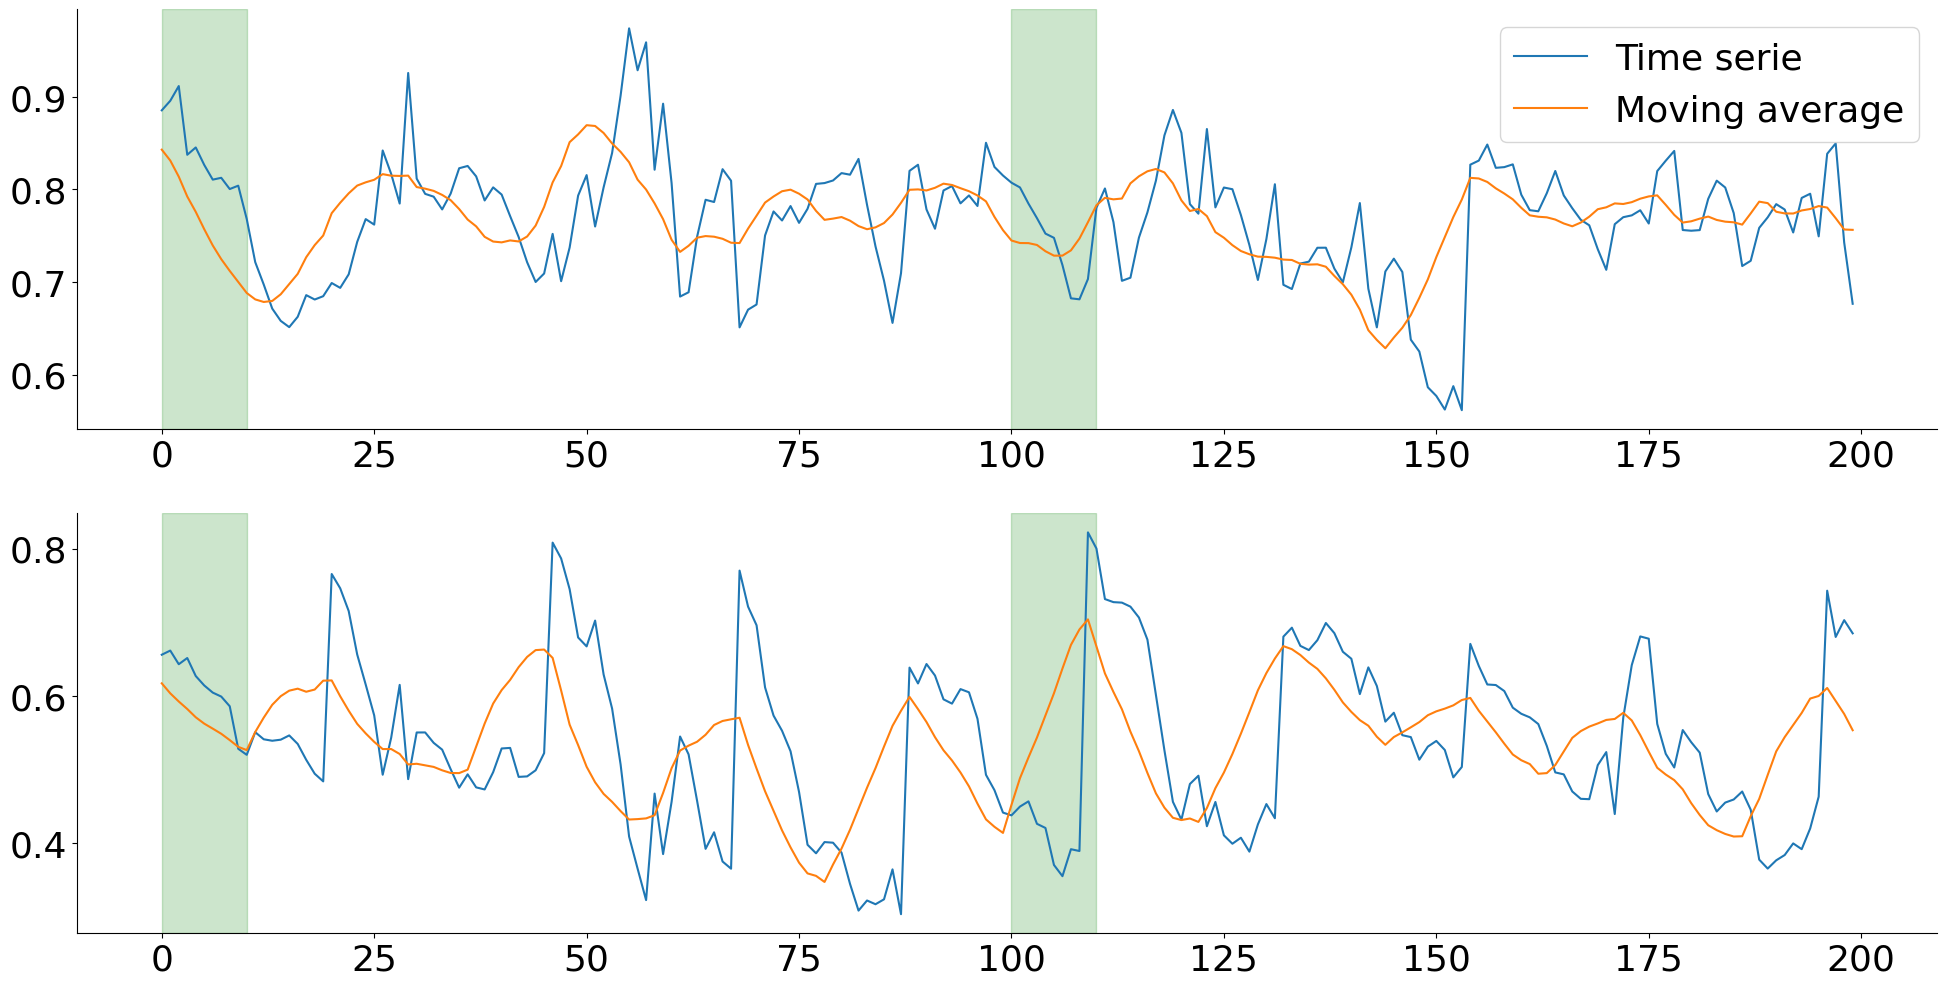

In [18]:
if is_instances_classification:
    train_band_data =  np.concatenate( X_train_band_duplicated, axis=0).T
else:
    train_band_data =  X_train_band_duplicated.T


#Compute the moving average 
window_size = 10
if max_window_size <= window_size or  window_size <= min_window_size:
    raise ValueError(f"window_size must be greater than {min_window_size} and smaller than {max_window_size}. Current window_size is {window_size}.")
weights = np.repeat(1.0, window_size)/window_size
ma = np.array([np.convolve(d, weights, 'valid') for d in (train_band_data)])

START = 0
END = 200
DIFF = END - START
#CPlot the two for different frequencies
NB_1 = 0
fig, ax = plt.subplots(2, 1, figsize=(24,12))
ax[0].plot(range(DIFF), train_band_data[NB_1, START:END], label='Time serie')
ax[0].plot(range(DIFF), ma[NB_1, START:END], label='Moving average')
ax[0].legend(fontsize=26)

NB_2 = 78
ax[1].plot(range(DIFF), train_band_data[NB_2, START:END], label='Time serie')
ax[1].plot(range(DIFF), ma[NB_2, START:END], label='Moving average')

for i, ax in enumerate(ax):
    # Format subplot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', labelsize=26)
    # draw vertical lines to show the window_size
    for x in range(START, END, 100):
        ax.axvspan(x, x + window_size, color='g', alpha=0.2)

plt.show()

## Function to initialise and generate reservoir

In [19]:
from reservoir.reservoir import init_matrices
from connexion_generation.bounded_hadsp import run_hadsp_algorithm
from connexion_generation.desp import run_desp_algorithm

input_connectivity = 1
connectivity = 0

def initialise_and_train(input_scaling, n, input_connectivity, connectivity, bias_scaling, seed, training_set):
    
    Win, W, bias = init_matrices(n, input_connectivity, connectivity, seed=seed)
    bias *= bias_scaling
    Win *= input_scaling

    #W, state_history = run_hadsp_algorithm(W, Win, bias, leaky_rate, activation_function, training_set, TIME_INCREMENT, WEIGHT_INCREMENT,
    #                       target_rate, RATE_SPREAD, max_increment=MAX_TIME_INCREMENT, mi_based=False, visualize=False)
    #variance_history=None
    W, state_history, variance_history = run_desp_algorithm(W, Win, bias, leaky_rate, activation_function, training_set, TIME_INCREMENT, WEIGHT_INCREMENT,
                        min_variance, max_variance, max_increment=MAX_TIME_INCREMENT, mi_based=True, instances=is_instances_classification,
                                                        n_jobs = 12, visualize=False)

    connectivity =  W.count_nonzero() / (W.shape[0] * W.shape[1])
    eigen = sparse.linalg.eigs(W, k=1, which="LM", maxiter=W.shape[0] * 20, tol=0.1, return_eigenvectors=False)
    sr = np.max(np.abs(eigen))
    
    return Win, W, bias, connectivity, sr, state_history, variance_history


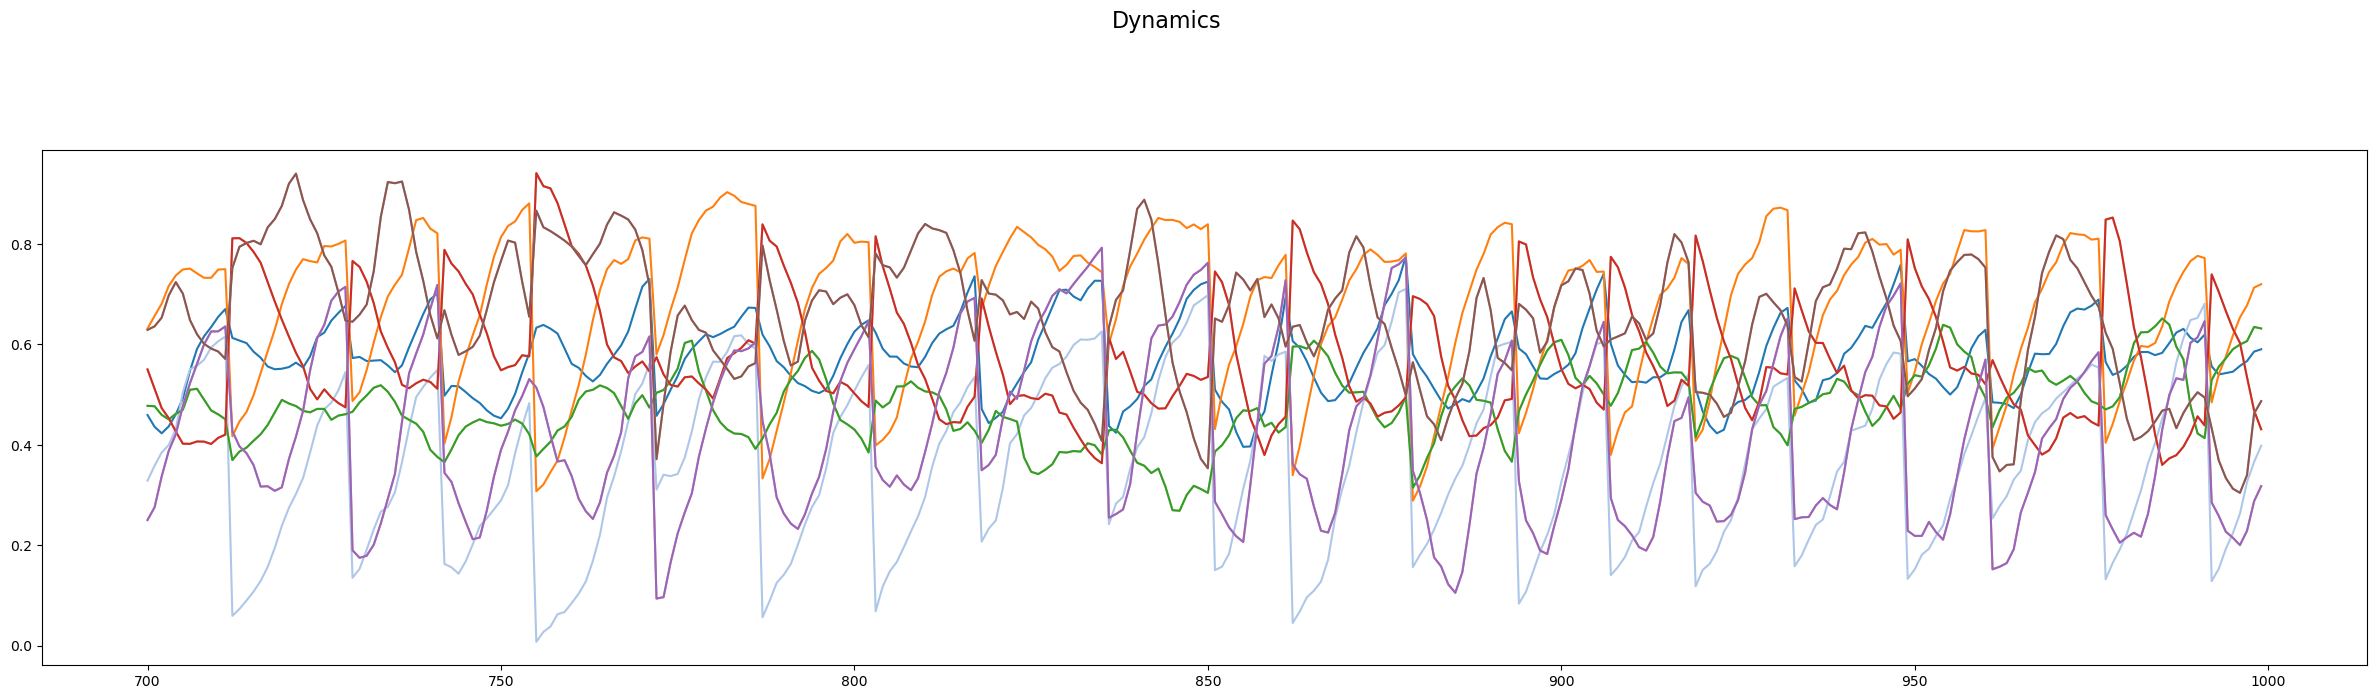

In [20]:
plt.figure(figsize=(30,14))
plt.suptitle(f'Dynamics', fontsize=16)

if is_instances_classification:
    xtrain_to_plot =  np.concatenate(X_pretrain_multi, axis=1)
else:
    xtrain_to_plot = X_pretrain_multi.T
    
# NEURON ACTIVITY PLOT 
ax0 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=2)
random_neurons_indices =  np.sort(np.random.randint(common_size*K, size=11)) #Size max is 19 because there is not enough colors
colors = color_palette("tab20")
# NUMBER_OF_STEP_TO_WATCH 
WATCH_FROM = 700
WATCH_TO = 1000
x =range(WATCH_FROM, WATCH_TO)
j = 0
for i in random_neurons_indices:
    ax0.plot(x, xtrain_to_plot[i][x], label=str(i), color=colors[j])
    j += 1


## Multivariate case

100%|███████████████████████████████████████████████████| 240/240 [04:19<00:00,  1.08s/it]


<Axes: >

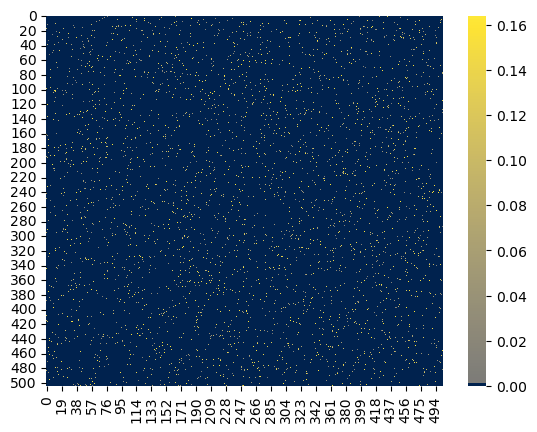

In [22]:
# HADSP
(Win_hadsp_multi, 
 W_hadsp_multi, 
 bias_hadsp_multi, 
 connectivity_band, 
 sr_hadsp_multi, 
 state_history_multi,
 variance_history) = initialise_and_train(input_scaling, n, input_connectivity, connectivity, bias_scaling, SEED, X_pretrain_multi)

# random + multi
Win_random_multi, W_random_multi, bias_random_multi =  init_matrices(n, 1, connectivity_band, sr_hadsp_multi)
bias_random_multi= bias_random_multi*bias_scaling
Win_random_multi= Win_random_multi*input_scaling

eigen_random_multi = sparse.linalg.eigs(W_random_multi, k=1, which="LM", maxiter=W_random_multi.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr_random_multi = np.max(np.abs(eigen_random_multi))

from matplotlib.colors import ListedColormap

custom_colormap = ListedColormap(np.vstack((plt.cm.cividis(0.0), plt.cm.cividis(np.linspace(0.5, 1, 128)))))
heatmap(W_random_multi.todense(), cmap=custom_colormap, cbar=True)

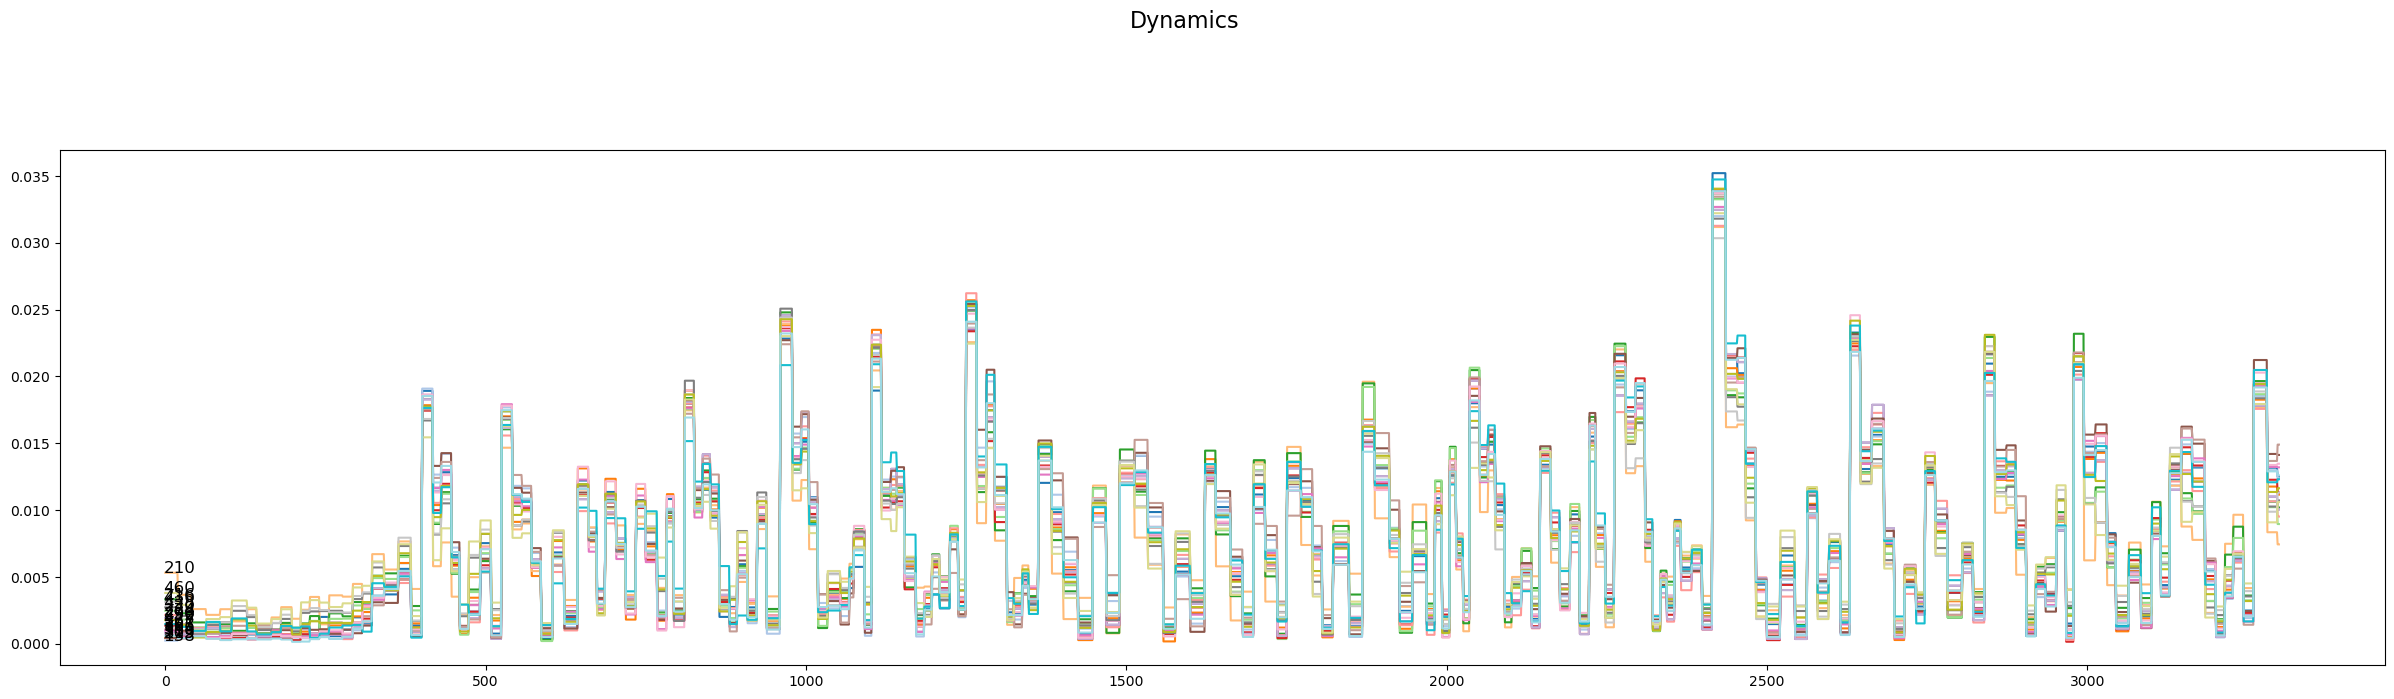

In [23]:
if variance_history is not None:
    plt.figure(figsize=(30,14))
    plt.suptitle(f'Dynamics', fontsize=16)
    
    # NEURON ACTIVITY PLOT
    ax0 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=2)
    random_neurons_indices =  np.sort(np.random.randint(RESERVOIR_SIZE, size=19)) #Size max is 19 because there is not enough colors
    random_neurons_indices = np.append(random_neurons_indices, 51)
    colors = color_palette("tab20")
    # NUMBER_OF_STEP_TO_WATCH 
    WATCH_FROM = 0
    WATCH_TO = 3300
    neurons_evolution = np.array(variance_history)[WATCH_FROM:WATCH_TO]
    x =range(len(state_history_multi))[WATCH_FROM:WATCH_TO]
    j = 0
    for i in random_neurons_indices:
        ax0.plot(x, neurons_evolution[: ,i], label=str(i), color=colors[j])
        ax0.text(-3+WATCH_FROM, neurons_evolution[0, i],  str(i), color="black", fontsize=12)
        j += 1


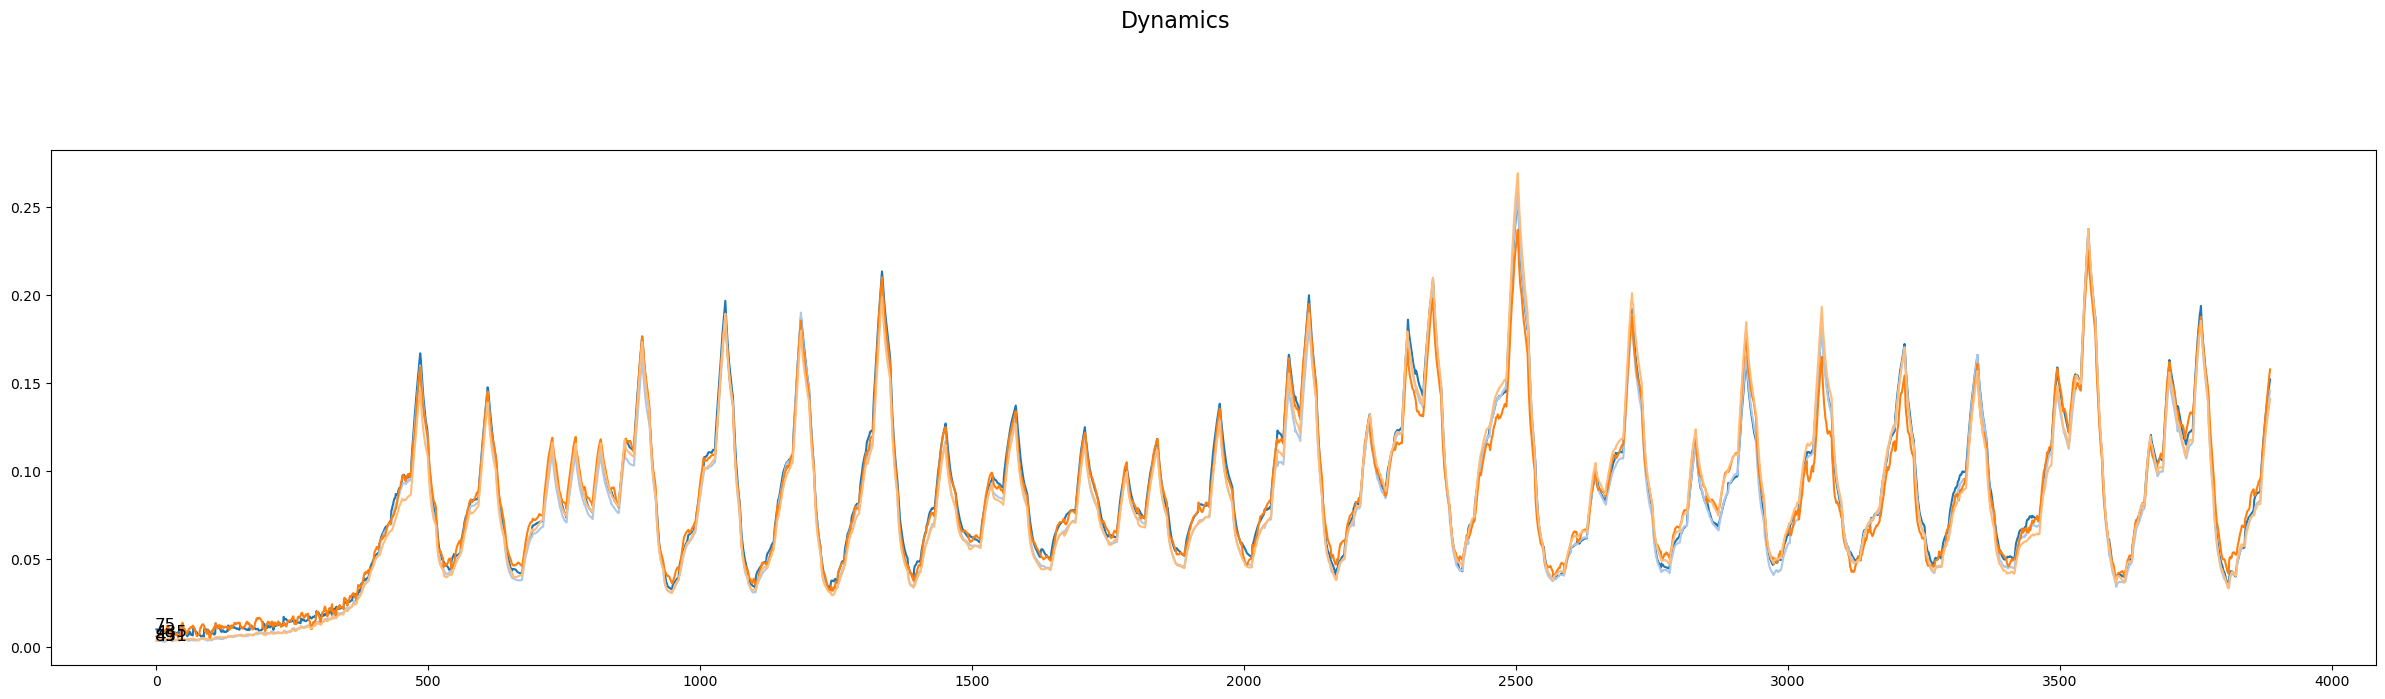

In [24]:
plt.figure(figsize=(30,14))
plt.suptitle(f'Dynamics', fontsize=16)

# NEURON ACTIVITY PLOT 
ax0 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=2)
random_neurons_indices =  np.sort(np.random.randint(RESERVOIR_SIZE, size=4)) #Size max is 19 because there is not enough colors
colors = color_palette("tab20")
# NUMBER_OF_STEP_TO_WATCH 
WATCH_FROM = 0
WATCH_TO = 4000
neurons_evolution = np.array(state_history_multi)[WATCH_FROM:WATCH_TO]
x =range(len(state_history_multi))[WATCH_FROM:WATCH_TO]
j = 0
for i in random_neurons_indices:
    ax0.plot(x, neurons_evolution[: ,i], label=str(i), color=colors[j])
    ax0.text(-3+WATCH_FROM, neurons_evolution[0, i],  str(i), color="black", fontsize=12)
    j += 1


## Univariate case

In [25]:
if not is_multivariate:
    # HADSP + uni
    (Win_hadsp_uni, 
     W_hadsp_uni, 
     bias_hadsp_uni, 
     connectivity_hadsp_uni, 
     sr_hadsp_uni,
     state_history_hadsp_uni,
     _) = initialise_and_train(input_scaling, n, input_connectivity, connectivity, bias_scaling, SEED, X_pretrain_uni)
    
    # random + uni
    Win_normal, W_normal, bias_normal = init_matrices(n, 1, connectivity_hadsp_uni, sr_hadsp_uni)
    bias_normal= bias_normal*bias_scaling
    Win_normal= Win_normal*input_scaling
    
    eigen_normal = sparse.linalg.eigs(W_normal, k=1, which="LM", maxiter=W_normal.shape[0] * 20, tol=0.1, return_eigenvectors=False)
    sr_normal = np.max(np.abs(eigen_normal))
    
    from matplotlib.colors import ListedColormap
    
    custom_colormap = ListedColormap(np.vstack((plt.cm.cividis(0.0), plt.cm.cividis(np.linspace(0.5, 1, 128)))))
    heatmap(W_hadsp_uni.todense(), cmap=custom_colormap, cbar=True)

In [26]:
print(connectivity_band)
if not is_multivariate:
    print(connectivity_hadsp_uni)


0.022565507684555303


## Spectral radius normalisation

In [27]:
print(sr_hadsp_multi)
print(sr_random_multi)
if not is_multivariate:
    print(sr_normal)
    print(sr_hadsp_uni)

0.9272092858885645
0.9272092894776922


# Performance

In [28]:
from joblib import Parallel, delayed
from sklearn.metrics import mutual_info_score

N_JOBS = -1
RIDGE_COEF= 1e-6

## Classification

### Classification for multivariate

In [29]:
print("X_train_band_duplicated example shape :", X_train_band_duplicated[1].shape)     
print("We should have :", X_train_band_duplicated[0].shape[1], "==", n)

X_train_band_duplicated example shape : (26, 504)
We should have : 504 == 504


In [30]:
import performances.esn_model_evaluation
reload(performances.esn_model_evaluation)
from performances.esn_model_evaluation import init_and_train_model_for_classification
# To remember : 
#  For reservoirpy   pre_s = W @ r + Win @ (u + noise_gen(dist=dist, shape=u.shape, gain=g_in)) + bias

train_data_multi = X_train_band_duplicated # X_train_band_noisy_duplicated or X_train_band_duplicated

reservoir_hadsp_multi, readout_hadsp_multi = init_and_train_model_for_classification(W_hadsp_multi, np.diag(Win_hadsp_multi.A.T[0]), bias_hadsp_multi, leaky_rate, activation_function, train_data_multi, Y_train, N_JOBS, RIDGE_COEF, mode="sequence-to-vector")

reservoir_random_multi, readout_random_multi = init_and_train_model_for_classification(W_random_multi, np.diag(Win_random_multi.A.T[0]), bias_random_multi, leaky_rate, activation_function, train_data_multi, Y_train, N_JOBS, RIDGE_COEF, mode="sequence-to-vector")


Processing: 100%|█████████████████████████████████████| 243/243 [00:00<00:00, 1973.82it/s]


#### noisy 

In [31]:
import performances.esn_model_evaluation
reload(performances.esn_model_evaluation)
from performances.esn_model_evaluation import predict_model_for_classification, compute_score

test_data_multi = X_test_band_noisy_duplicated # X_test_band_noisy_duplicated or X_test_band_duplicated

Y_pred_hadsp_multi = predict_model_for_classification(reservoir_hadsp_multi, readout_hadsp_multi, test_data_multi, N_JOBS)
score = compute_score(Y_pred_hadsp_multi, Y_test, is_instances_classification, "HADSP multi", verbosity=1)

Y_pred_random_multi = predict_model_for_classification(reservoir_random_multi, readout_random_multi, test_data_multi, N_JOBS)
score = compute_score(Y_pred_random_multi, Y_test, is_instances_classification, "random multi", verbosity=1)

Evaluating: 100%|█████████████████████████████████████| 370/370 [00:00<00:00, 1967.71it/s]


Accuracy for HADSP multi: 73.514 %


Evaluating: 100%|█████████████████████████████████████| 370/370 [00:00<00:00, 3203.77it/s]


Accuracy for random multi: 72.703 %


#### normal

In [32]:

test_data_multi = X_test_band_duplicated # X_test_band_noisy_duplicated or X_test_band_duplicated

Y_pred_hadsp_multi = predict_model_for_classification(reservoir_hadsp_multi, readout_hadsp_multi, test_data_multi, -1)
score = compute_score(Y_pred_hadsp_multi, Y_test, is_instances_classification, "HADSP multi", verbosity=1)

Y_pred_random_multi = predict_model_for_classification(reservoir_random_multi, readout_random_multi, test_data_multi, N_JOBS)
score = compute_score(Y_pred_random_multi, Y_test, is_instances_classification, "random multi", verbosity=1)

Evaluating: 100%|█████████████████████████████████████| 370/370 [00:00<00:00, 3388.46it/s]


Accuracy for HADSP multi: 89.730 %


Evaluating: 100%|█████████████████████████████████████| 370/370 [00:00<00:00, 3453.37it/s]


Accuracy for random multi: 90.270 %


### Classification for univariate

In [33]:
if not is_multivariate: 
    # Create a list to store the arrays with the same shape as the expected input of the reservoir

    train_data_uni = [ts.reshape(-1, 1) for ts in X_train]
    test_data_uni = [ts.reshape(-1, 1) for ts in X_test]

    print("number of instances in train_data_uni :", len(train_data_uni), "should be equal to", len(X_train))     
    print("example of train_data_uni train shape :", train_data_uni[0].shape)     
    print("We should have :", train_data_uni[0].shape[1], "==", 1)

In [34]:
if not is_multivariate:
    reservoir_hadsp_uni, readout_hadsp_uni = init_and_train_model_for_classification(W_hadsp_uni, Win_hadsp_uni, bias_hadsp_uni, activation_function, RIDGE_COEF, train_data_uni, Y_train, N_JOBS)
    
    reservoir_random_uni, readout_random_uni = init_and_train_model_for_classification(W_normal, Win_normal, bias_normal, activation_function, RIDGE_COEF, train_data_uni, Y_train, N_JOBS)

In [35]:
if not is_multivariate:
    Y_pred_hadsp_uni = predict_model_for_classification(reservoir_hadsp_uni, readout_hadsp_uni, test_data_uni, N_JOBS)
    score = compute_score(Y_pred_hadsp_uni, Y_test, "HADSP uni")
    
    Y_pred_normal = predict_model_for_classification(reservoir_random_uni, readout_random_uni, test_data_uni, N_JOBS)
    score = compute_score(Y_pred_normal, Y_test, "random uni")

## Prediction ahead

In [ ]:
if is_instances_classification:
    raise ValueError("This is not the right Classification section.")

### Plot datasets
Noisy or normal dataset can be ploted

In [ ]:
# Concatenate train and test arrays for plotting
combined_data = np.concatenate((X_train_band_duplicated, X_val_band_duplicated), axis=0)

# noisy version
combined_data_noisy = np.concatenate((X_train_band_duplicated, X_val_band_noisy_duplicated), axis=0)
combined_Y =np.concatenate((Y_train, Y_val), axis=0)

# Calculate the merge point index
merge_point_index = X_train_band_duplicated.shape[0]

# Define the range around the merge point to plot
start_index = merge_point_index - 100
end_index = merge_point_index + 100

# Plot for a subset N features within a range arround transition from train to test
N = 3
plt.figure(figsize=(16, 5))
for i in [63, 178, 473]: 
    plt.plot(range(start_index, end_index), combined_data_noisy[start_index:end_index, i], label=f'Feature {i}')
plt.plot(range(start_index, end_index), combined_Y[start_index:end_index], label="Prediction")
plt.title('Feature Values Around Merge Point')
plt.xlabel('Sample Index')
plt.ylabel('Feature Value')
plt.legend()
plt.show()

### Training
Noisy or normal dataset can be used

In [ ]:
from performances.esn_model_evaluation import init_and_train_model_for_prediction

if not is_multivariate:
    train_data_uni = X_train # X_train_noisy or X_train
    
    # Training random + MG
    esn_random_uni = init_and_train_model_for_prediction(W_normal, Win_normal, bias_normal, leaky_rate, activation_function, train_data_uni, Y_train, RIDGE_COEF)
    
    # Training for HADSP + MG
    esn_hadsp_uni = init_and_train_model_for_prediction(W_hadsp_uni, Win_hadsp_uni, bias_hadsp_uni, leaky_rate, activation_function, train_data_uni, Y_train, RIDGE_COEF)

train_data_multi = X_train_band_duplicated # X_train_band_noisy or train_band_inputs

# Training random + bandfilter
esn_random_multi = init_and_train_model_for_prediction(W_random_multi, np.diag(Win_random_multi.A.T[0]), bias_random_multi, leaky_rate, activation_function, train_data_multi, Y_train, RIDGE_COEF)

# Training output HASDP + bandfilter
esn_hadsp_multi = init_and_train_model_for_prediction(W_hadsp_multi, np.diag(Win_hadsp_multi.A.T[0]), bias_hadsp_multi, leaky_rate, activation_function, train_data_multi, Y_train, RIDGE_COEF)
                                                                                   

### Prediction
Noisy or normal dataset can be used

In [ ]:
from reservoir.reservoir import run

if not is_multivariate:
    test_data_uni = X_val_noisy # X_val_noisy or X_val

    # Prediction for random + MG
    y_pred_random_uni = esn_random_uni.run(test_data_uni, reset=False) 

    # Prediction for HADSP + MG
    y_pred_hadsp_uni = esn_hadsp_uni.run(test_data_uni, reset=False) 

test_data_multi = X_test_band_duplicated # X_test_band_noisy_duplicated or X_test_band_duplicated

# Prediction for random + bandfilter
y_pred_random_multi = esn_random_multi.run(test_data_multi, reset=False)

# Prediction for HADSP + bandfilter
y_pred_hadsp_multi = esn_hadsp_multi.run(test_data_multi, reset=False)


In [ ]:
from plots.plots import plot_results
from performances.esn_model_evaluation import compute_score

START_STEP = 30
END_STEP = 500
slice_range = slice(START_STEP, END_STEP)

if not is_multivariate:
    print("nrmse normal         :", compute_score(Y_val[slice_range], y_pred_random_uni[slice_range], is_instances_classification))
    print("nrmse hadsp          :", compute_score(Y_val[slice_range], y_pred_hadsp_uni[slice_range], is_instances_classification))
print("nrmse random + band  :", compute_score(Y_val[slice_range], y_pred_random_multi[slice_range], is_instances_classification))
print("nrmse hadsp + band   :", compute_score(Y_val[slice_range], y_pred_hadsp_multi[slice_range], is_instances_classification))

plot_results(y_pred_hadsp_multi, Y_test, 0, 300)


In [ ]:
from reservoir.reservoir import run

if not is_multivariate:
    test_data_uni = X_val_noisy # X_val_noisy or X_val

    # Prediction for random + MG
    y_pred_random_uni = esn_random_uni.run(test_data_uni, reset=False) 

    # Prediction for HADSP + MG
    y_pred_hadsp_uni = esn_hadsp_uni.run(test_data_uni, reset=False) 

test_data_multi = X_test_band_noisy_duplicated # X_test_band_noisy_duplicated or X_test_band_duplicated

# Prediction for random + bandfilter
y_pred_random_multi = esn_random_multi.run(test_data_multi, reset=False)

# Prediction for HADSP + bandfilter
y_pred_hadsp_multi = esn_hadsp_multi.run(test_data_multi, reset=False)


In [ ]:
from plots.plots import plot_results

START_STEP = 30
END_STEP = 500
slice_range = slice(START_STEP, END_STEP)

if not is_multivariate:
    print("nrmse normal         :", compute_score(y_pred_random_uni[slice_range], Y_val[slice_range], is_instances_classification))
    print("nrmse hadsp          :", compute_score(y_pred_hadsp_uni[slice_range], Y_val[slice_range], is_instances_classification))
print("nrmse random + band  :", compute_score(y_pred_random_multi[slice_range], Y_val[slice_range], is_instances_classification))
print("nrmse hadsp + band   :", compute_score(y_pred_hadsp_multi[slice_range], Y_val[slice_range], is_instances_classification))

plot_results(y_pred_hadsp_multi, Y_test, 0, 300)


#### Moving average 

In [ ]:
from performances.esn_model_evaluation import compute_score

# moving average of the y
span=7
pad_width = span // 2

ave_y_random_uni = np.convolve(np.pad(y_pred_random_uni.flatten(), pad_width, mode='edge'), np.ones(span), 'valid') / span
ave_y_hadsp_uni = np.convolve(np.pad(y_pred_hadsp_uni.flatten(), pad_width, mode='edge') , np.ones(span), 'valid') / span
ave_y_random_multi = np.convolve(np.pad(y_pred_random_multi.flatten(), pad_width, mode='edge'), np.ones(span), 'valid') / span
ave_y_hadsp_multi = np.convolve(np.pad(y_pred_hadsp_multi.flatten(), pad_width, mode='edge'), np.ones(span), 'valid') / span


print("nrmse normal         :", compute_score(ave_y_random_uni[slice_range], Y_val[slice_range], is_instances_classification))
print("nrmse hadsp          :", compute_score(ave_y_hadsp_uni[slice_range], Y_val[slice_range], is_instances_classification))
print("nrmse random + band  :", compute_score(ave_y_random_multi[slice_range], Y_val[slice_range], is_instances_classification))
print("nrmse hadsp + band   :", compute_score(ave_y_hadsp_multi[slice_range], Y_val[slice_range], is_instances_classification))
 
plot_results(ave_y_hadsp_multi.reshape(-1,1), Y_test, 300)

In [ ]:
nrmse_array_random_uni = []
nrmse_array_hadsp_uni = []
nrmse_array_random_multi = []
nrmse_array_hadsp_multi = []

for i in range(len(Y_val)-100- step_ahead):
    Y_val_i = Y_val[i:100+i]
    nrmse_array_random_uni.append(compute_score(Y_val_i, y_pred_random_uni[i:100+i], is_instances_classification))
    nrmse_array_hadsp_uni.append(compute_score(Y_val_i, y_pred_hadsp_uni[i:100+i], is_instances_classification))
    nrmse_array_random_multi.append(compute_score(Y_val_i, y_pred_random_multi[i:100+i], is_instances_classification))
    nrmse_array_hadsp_multi.append(compute_score(Y_val_i, y_pred_hadsp_multi[i:100+i], is_instances_classification))
    
log10_nrmse_random_uni= np.log10(nrmse_array_random_uni)
log10_nrmse_hadsp_uni = np.log10(nrmse_array_hadsp_uni)
log10_nrmse_random_multi = np.log10(nrmse_array_random_multi)
log10_nrmse_hadsp_multi = np.log10(nrmse_array_hadsp_multi)
plt.figure()
plt.plot(log10_nrmse_random_uni[:1000])
plt.plot(log10_nrmse_hadsp_uni[:1000])
plt.plot(log10_nrmse_random_multi[:1000])
plt.plot(log10_nrmse_hadsp_multi[:1000])

plt.xlabel('Time steps')
plt.ylabel('Log10 NRMSE')
plt.legend(["HADSP+band", "random", " random + bandfilter", "HADSP"])
plt.show()

# Analysis

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import linkage, leaves_list

scaler = MinMaxScaler(feature_range=(-1, 1))

# pretrain
# Be really carefull of the column order here !
df_data = scaler.fit_transform(X_pretrain_band.T)
df_data = df_data.T
df = pd.DataFrame(df_data.T)
# Initialize a progress bar for total number of series
progress_bar = tqdm(total=df.shape[1]**2, position=0, leave=True)

# Initialize an empty correlation matrix
correlation_matrix = pd.DataFrame(index=df.columns, columns=df.columns)

# Calculate the correlation for each pair of series
for col1 in df.columns:
    progress_bar.set_description(f"Processing {col1}")
    for col2 in df.columns:
        correlation_matrix.loc[col1, col2] = df[col1].corr(df[col2], method='pearson', min_periods=5)

        progress_bar.update(1)  # Update the progress bar after processing each series
    
progress_bar.close()

# Convert correlation_matrix to numeric as it is stored as objects due to tqdm
correlation_matrix = correlation_matrix.apply(pd.to_numeric)

# Perform hierarchical clustering
linked = linkage(correlation_matrix, 'single')

# Get the order of rows/columns after hierarchical clustering
row_order = leaves_list(linked)

# Reorder the correlation matrix
sorted_corr_matrix = correlation_matrix.iloc[row_order, :].iloc[:, row_order]

# Visualize the sorted correlation matrix with a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(sorted_corr_matrix, annot=False, cmap='vlag', vmin=-1, vmax=1)
plt.title('Clustered Pairwise Correlation of Time Series')
plt.show()


In [ ]:
from scipy.sparse import coo_matrix

row_order_r = np.array([i + k for i in row_order*K for k in range(K)])

# Convert the sparse matrix to a dense format (if memory allows)
dense_matrix = W_hadsp_multi.toarray()

# Reorder the dense matrix using the repeated ordering
reordered_matrix = dense_matrix[np.ix_(row_order_r, row_order_r)]

# Convert the reordered dense matrix back to a sparse format if needed
sparse_reordered_matrix = coo_matrix(reordered_matrix)

In [ ]:
heatmap(sparse_reordered_matrix.todense(), cmap=color_palette("vlag", as_cmap=True))

## Motifs

In [ ]:
import analysis.topology
reload(analysis.topology)
from analysis.topology import motif_distribution, draw_motifs_distribution

motifs_count = motif_distribution(W_hadsp_multi.A)
draw_motifs_distribution(motifs_count)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, binom

def analyze_connectivity_matrix(matrix):
    # Extract weights from the matrix (ignoring the diagonal and zeros)
    weights = matrix.flatten()
    weights = weights[weights != 0]
    bin_centers, counts = np.unique(weights, return_counts=True)
    
    # Calculate the difference for all centers
    diffs = np.diff(bin_centers)
    # Add the last difference for the last bin
    diffs = np.append(diffs, diffs[-1])
    
    # Calculate the bin edges based on bin centers and differences
    bin_edges = bin_centers - diffs/2
    # Add the last bin edge
    bin_edges = np.append(bin_edges, bin_centers[-1] + diffs[-1]/2)
    
    # Plot histogram
    plt.bar(bin_centers, counts, align='center', alpha=0.6, width=np.diff(bin_centers).min())
    
    # Fit to Poisson distribution
    lambda_est = np.mean(weights)
    plt.plot(bin_centers, poisson.pmf(range(len(bin_centers)), lambda_est)*counts[0], 'r-', label='Poisson fit')
    
    # Fit to Binomial distribution using derived relations
    mean = np.mean(weights)
    variance = np.var(weights)
    
    # Calculate p and n estimates
    p_est = mean ** 2 / (n * mean - variance) if (n * mean - variance) != 0 else 0
    n_est = int(round(mean / p_est)) if p_est != 0 else 0  # n should be integer

    # Check parameter validity
    if not(0 < p_est < 1):
        print("Estimated parameters are not valid for the Binomial distribution.")
    else:
        x_vals = range(len(bin_centers))
        plt.plot(bin_centers, binom.pmf(x_vals, n_est, p_est) * counts[0], 'g-', label='Binomial fit')

    plt.legend()
    plt.show()

    return {"Poisson": lambda_est, "Binomial": (n_est, p_est)}


# Assuming W_hadsp_multi.A is your connectivity matrix
analyze_connectivity_matrix(W_hadsp_multi.A)

In [ ]:
bin_centers = np.array([1.5, 3.5, 5.5, 7.5])
poisson.pmf(np.arange(len([1, 2, 3, 4, 5, 6])), 0.08)

In [ ]:
weights.shape

In [ ]:
W_hadsp_multi.A.flatten().shape